In [ ]:
!pip install captcha
!pip install Pillow
!pip install seaborn

In [ ]:
!git clone https://github.com/JackonYang/captcha-tensorflow.git

In [ ]:
!python captcha-tensorflow/datasets/gen_captcha.py -d --npi 4 -n 4 # add -c 1000 to create the smaller dataset or you can write -c 3300 for small datasets(part 1 it gives low accuracy)

10 choices: 0123456789
generating 4 epoches of captchas in ./images/char-4-epoch-4/train.
(1/4) epoches finished
(2/4) epoches finished
(3/4) epoches finished
(4/4) epoches finished
write meta info in ./images/char-4-epoch-4/meta.json


In [ ]:
!zip -r /content/images/char-4-epoch-4.zip /content/images/char-4-epoch-4

updating: content/images/char-4-epoch-4/ (stored 0%)
updating: content/images/char-4-epoch-4/meta.json (deflated 31%)
updating: content/images/char-4-epoch-4/train/ (stored 0%)
  adding: content/images/char-4-epoch-4/train/3275_1a650dc8-ca13-4a63-a274-6f8891fba13d.png (stored 0%)
  adding: content/images/char-4-epoch-4/train/2174_354828b8-7dd0-48a8-8adc-585d50c087be.png (stored 0%)
  adding: content/images/char-4-epoch-4/train/6903_526b2544-49c0-4f7b-a8e1-14375f20f4b2.png (stored 0%)
  adding: content/images/char-4-epoch-4/train/7069_c2cb3dc5-5464-4f75-bcb3-fcf6063ae413.png (stored 0%)
  adding: content/images/char-4-epoch-4/train/9014_37f36577-363f-4a2a-8990-cf245ce2cba8.png (stored 0%)
  adding: content/images/char-4-epoch-4/train/7043_a39db5ea-f5df-4f51-8039-90771597f495.png (stored 0%)
  adding: content/images/char-4-epoch-4/train/2039_fdc77095-ec74-487b-89b5-eabccafeb591.png (stored 0%)
  adding: content/images/char-4-epoch-4/train/5940_fb7da505-23a5-4273-aff5-8e34b0b1842a.png (st

In [ ]:
from google.colab import files
files.download("/content/images/char-4-epoch-4.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#PART 2 run all cells below for PART 2
!unzip "/content/merge_upload.zip" -d "/content/images/"

Archive:  /content/merge_upload.zip
replace /content/images/merge_upload/0230.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

import os
import time
import json
import glob

import matplotlib.pyplot as plt
from PIL import Image

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns

tf.__version__

DATA_DIR = './images/char-4-epoch-4/train'
H, W, C = 100, 120, 3  # height, width, 3(RGB channels)
N_LABELS = 256
D = 4 # num_per_image

In [ ]:
#PART1 - DO NOT RUN THIS CELL FOR PART 2
def parse_filepath(filepath):
    try:
        path, filename = os.path.split(filepath)
        filename, ext = os.path.splitext(filename)
        label, _ = filename.split("_")
        return label
    except Exception as e:
        print('error to parse %s. %s' % (filepath, e))
        return None, None

In [ ]:
#PART2
def parse_filepath(filepath):
    try:
        path, filename = os.path.split(filepath)
        filename, ext = os.path.splitext(filename)
        label = filename
        return label
    except Exception as e:
        print('error to parse %s. %s' % (filepath, e))
        return None, None

In [ ]:
#PART 1 & 2
# create a pandas data frame of images, age, gender and race
files = glob.glob(os.path.join(DATA_DIR, "*.png"))
attributes = list(map(parse_filepath, files))

df = pd.DataFrame(attributes)
df['file'] = files
df.columns = ['label', 'file']
df = df.dropna()
df.head()

,label,file
0,1829,./images/char-4-epoch-4/train/1829_589d4f01-31...
1,7360,./images/char-4-epoch-4/train/7360_09966b5c-a7...
2,0874,./images/char-4-epoch-4/train/0874_d4b45cc4-3e...
3,4786,./images/char-4-epoch-4/train/4786_eeb987fd-6f...
4,4198,./images/char-4-epoch-4/train/4198_45baf29b-30...


In [ ]:
p = np.random.permutation(len(df))
train_up_to = int(len(df) * 0.8) #change this increasing this may increase acc.
train_idx = p[:train_up_to]
test_idx = p[train_up_to:]

# split train_idx further into training and validation set
train_up_to = int(train_up_to * 0.8)
train_idx, valid_idx = train_idx[:train_up_to], train_idx[train_up_to:]

print('train count: %s, valid count: %s, test count: %s' % (
    len(train_idx), len(valid_idx), len(test_idx)))

from tensorflow.keras.utils import to_categorical
from PIL import Image


def get_data_generator(df, indices, for_training, batch_size=16):
    images, labels = [], []
    while True:
        for i in indices:
            r = df.iloc[i]
            file, label = r['file'], r['label']
            im = Image.open(file)
#             im = im.resize((H, W))
            im = np.array(im) / 255.0
            images.append(np.array(im))
            labels.append(np.array([np.array(to_categorical(ord(i), N_LABELS)) for i in label]))
            if len(images) >= batch_size:
#                 print(np.array(images), np.array(labels))
                yield np.array(images), np.array(labels)
                images, labels = [], []
        if not for_training:
            break

train count: 12902, valid count: 3226, test count: 4032


In [ ]:
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Conv2D, MaxPool2D, GlobalMaxPool2D, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Model

input_layer = tf.keras.Input(shape=(H, W, C))

#V1 - activatuon relu
x = layers.Conv2D(32, 3, activation='relu')(input_layer)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dense(1024, activation='relu')(x)

#V2 - activation relu maxpooling 4,4
#x = layers.Conv2D(32, 3, activation='relu')(input_layer)
#x = layers.MaxPooling2D((4, 4))(x)
#x = layers.Conv2D(64, 3, activation='relu')(x)
#x = layers.MaxPooling2D((4, 4))(x)
#x = layers.Conv2D(64, 3, activation='relu')(x)
#x = layers.Flatten()(x)
#x = layers.Dense(1024, activation='relu')(x)
#x = layers.Dropout(0.5)(x)

#V3 - activation gelu 
#x = layers.Conv2D(32, 3, activation='gelu')(input_layer)
#x = layers.MaxPooling2D((2, 2))(x)
#x = layers.Conv2D(64, 3, activation='gelu')(x)
#x = layers.MaxPooling2D((2, 2))(x)
#x = layers.Conv2D(64, 3, activation='gelu')(x)
#x = layers.MaxPooling2D((2, 2))(x)
#x = layers.Flatten()(x)
#x = layers.Dense(1024, activation='gelu')(x)


#V4 - activation gelu maxpooling 4, 4
#x = layers.Conv2D(32, 3, activation='gelu')(input_layer)
#x = layers.MaxPooling2D((4, 4))(x)
#x = layers.Conv2D(64, 3, activation='gelu')(x)
#x = layers.MaxPooling2D((4, 4))(x)
#x = layers.Conv2D(64, 3, activation='gelu')(x)
#x = layers.Flatten()(x)
#x = layers.Dense(1024, activation='gelu')(x)
#x = layers.Dropout(0.5)(x)


x = layers.Dense(D * N_LABELS, activation='softmax')(x)
x = layers.Reshape((D, N_LABELS))(x)

model = models.Model(inputs=input_layer, outputs=x)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), #change the learning rate here try -5,-1
              loss='categorical_crossentropy', #try with mse
              metrics= ['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 120, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 98, 118, 32)       896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 59, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 57, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 28, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 26, 64)        36928 

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

batch_size = 64 # change the bactchize, smaller may be better but traioning takes more time
valid_batch_size = 64
train_gen = get_data_generator(df, train_idx, for_training=True, batch_size=batch_size)
valid_gen = get_data_generator(df, valid_idx, for_training=True, batch_size=valid_batch_size)

callbacks = [
    ModelCheckpoint("./model_checkpoint", monitor='val_loss')
]


# TODO: Changed epoch (from 7-->1) for code testing -- faster convergence.
history = model.fit(train_gen,
                    steps_per_epoch=len(train_idx)//batch_size,
                    epochs=4, # Change the number of epochs
#                   callbacks=callbacks,
                    validation_data=valid_gen,
                    validation_steps=len(valid_idx)//valid_batch_size)



model.save("trial3")

Epoch 1/4
201/201 [==============================] - 119s 588ms/step - loss: 2.4442 - accuracy: 0.1005 - val_loss: 2.3164 - val_accuracy: 0.1009
Epoch 2/4
201/201 [==============================] - 118s 588ms/step - loss: 2.3276 - accuracy: 0.1022 - val_loss: 2.3083 - val_accuracy: 0.1148
Epoch 3/4
201/201 [==============================] - 120s 598ms/step - loss: 2.0160 - accuracy: 0.2570 - val_loss: 1.5370 - val_accuracy: 0.4548
Epoch 4/4
201/201 [==============================] - 116s 579ms/step - loss: 1.3523 - accuracy: 0.5190 - val_loss: 1.0468 - val_accuracy: 0.6446
INFO:tensorflow:Assets written to: trial3/assets


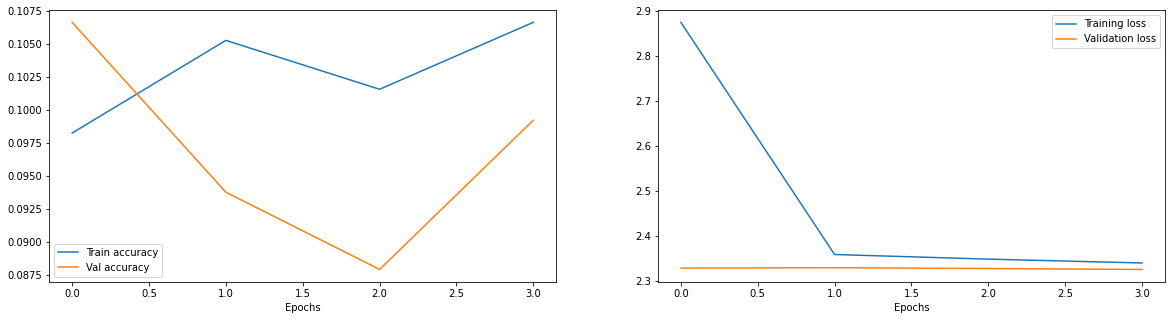

In [ ]:
def plot_train_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(20, 5))

    axes[0].plot(history.history['accuracy'], label='Train accuracy')
    axes[0].plot(history.history['val_accuracy'], label='Val accuracy')
    axes[0].set_xlabel('Epochs')
    axes[0].legend() 

    axes[1].plot(history.history['loss'], label='Training loss')
    axes[1].plot(history.history['val_loss'], label='Validation loss')
    axes[1].set_xlabel('Epochs')
    axes[1].legend()

plot_train_history(history)
plt.show()

In [ ]:
# evaluate loss and accuracy in test dataset
from tensorflow import keras
model_loaded = keras.models.load_model('trial3')
test_gen = get_data_generator(df, test_idx, for_training=False, batch_size=128)
dict(zip(model_loaded.metrics_names, model_loaded.evaluate(test_gen, steps=len(test_idx)//128)))

6/6 [==============================] - 3s 418ms/step - loss: 2.3256 - accuracy: 0.0999


{'accuracy': 0.0999348983168602, 'loss': 2.325573205947876}

pred: 0276
pred: 1907
pred: 1651
pred: 0915
pred: 6520
pred: 0631
pred: 3624
pred: 5963
pred: 5038
pred: 4392
pred: 0769
pred: 3479
pred: 4851
pred: 1493
pred: 1784
pred: 6309
pred: 8614
pred: 4520
pred: 4537
pred: 3641
pred: 9560
pred: 2367
pred: 8533
pred: 5321
pred: 9837
pred: 8294
pred: 2935
pred: 5692
pred: 8043
pred: 1350
pred: 0428
pred: 8295
pred: 1278
pred: 6285
pred: 3681
pred: 0857
pred: 2376
pred: 2541
pred: 8075
pred: 2764
pred: 1276
pred: 3258
pred: 7428
pred: 6408
pred: 3507
pred: 4631
pred: 7091
pred: 2896
pred: 3674
pred: 7154
pred: 2045
pred: 0134
pred: 3671
pred: 6132
pred: 6512
pred: 2849
pred: 6951
pred: 8497
pred: 7319
pred: 4582
pred: 3145
pred: 3170
pred: 2886
pred: 1426
pred: 0816
pred: 6508
pred: 6941
pred: 5946
pred: 2900
pred: 4675
pred: 7240
pred: 3274
pred: 4165
pred: 8509
pred: 1885
pred: 1682
pred: 1579
pred: 3809
pred: 2496
pred: 8430
pred: 6485
pred: 9521
pred: 7524
pred: 0588
pred: 4018
pred: 5343
pred: 0419
pred: 8450
pred: 6375
pred: 0367
pred: 0426

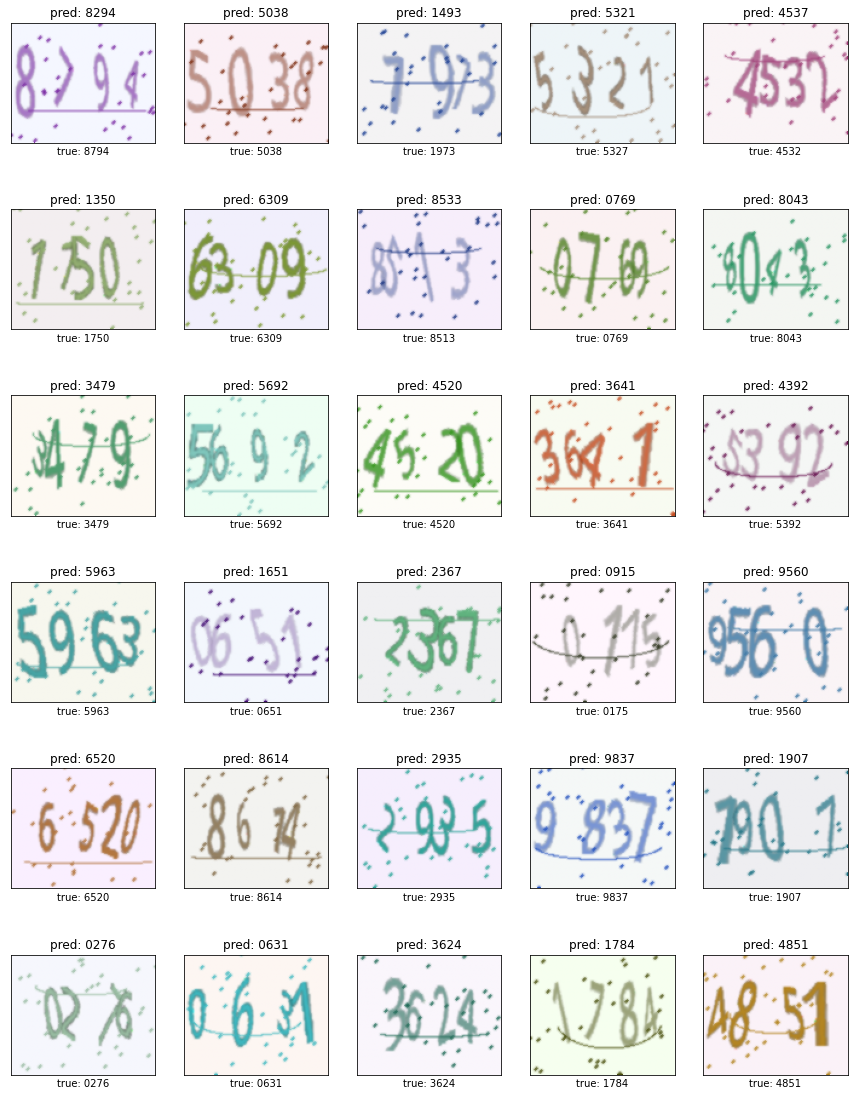

In [ ]:
test_gen = get_data_generator(df, test_idx, for_training=False, batch_size=128)
x_test, y_test = next(test_gen)
# print(test_gen)
# print("****")
# print(x_test)
# print("****")
# print(y_test)
y_pred = model_loaded.predict_on_batch(x_test)
y_true = tf.math.argmax(y_test, axis=-1)
y_pred = tf.math.argmax(y_pred, axis=-1)
# print(y_pred)

def format_y(y):
    return ''.join(map(lambda x: chr(int(x)), y))

for pred in range(len(y_pred)):
  print('pred: %s' % format_y(y_pred[pred]))

import math
n = 30
random_indices = np.random.permutation(n)
n_cols = 5
n_rows = math.ceil(n / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 20))
for i, img_idx in enumerate(random_indices):
    ax = axes.flat[i]
    ax.imshow(x_test[img_idx])
    ax.set_title('pred: %s' % format_y(y_pred[img_idx]))
    ax.set_xlabel('true: %s' % format_y(y_true[img_idx]))
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()